# In this notebook I've tried a one stem-Inception module architecture on Intel Image Classification dataset. My takeaway is to learn how each hyperparameter affects overfitting. 

## Importing modules

In [1]:
import os 
import numpy as np
import matplotlib.pyplot as plt
import cv2
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix

from keras.models import Model
from keras.layers import Flatten,Dense,Conv2D,MaxPooling2D,Dropout,concatenate,Add,Input
from keras import utils
from keras.optimizers import SGD

Using TensorFlow backend.


## Checking the path

In [2]:
os.listdir('../input/intel-image-classification/seg_train/seg_train')

['sea', 'forest', 'mountain', 'glacier', 'buildings', 'street']

## providing class labels

In [3]:
class_label = ['mountain','street','glacier','buildings','sea','forest']
class_label_names = {name:i for i,name in enumerate(class_label)}
class_label_names

{'mountain': 0,
 'street': 1,
 'glacier': 2,
 'buildings': 3,
 'sea': 4,
 'forest': 5}

## Function to load data from pre-classified folders

In [4]:
def load_data():
    data_set = ['../input/intel-image-classification/seg_train/seg_train',
               '../input/intel-image-classification/seg_test/seg_test']

    output = []

    #iterating through the train and test folders
    for data in data_set:

        image = []
        label = []

        for category in os.listdir(data):

            curr_label = class_label_names[category]

            for file in os.listdir(os.path.join(data,category)):

                img_path = os.path.join(data,category,file)

                curr_img = cv2.imread(img_path)
                curr_img = cv2.resize(curr_img,(150,150))

                image.append(curr_img)
                label.append(curr_label)

        image = np.array(image,dtype='float32')
        label = np.array(label,dtype='int32')

        output.append((image,label))

    return output

In [5]:
(trainX,trainY),(testX,testY)=load_data()

## Confirming the shape of the data

In [6]:
print('shape of trainX: ',trainX.shape, 'shape of trainY: ',trainY.shape)
print('shape of testX: ',testX.shape, 'shape of testY: ',testY.shape)

shape of trainX:  (14034, 150, 150, 3) shape of trainY:  (14034,)
shape of testX:  (3000, 150, 150, 3) shape of testY:  (3000,)


## Let's check if the train dataset contains equal number of data in each class

In [7]:
np.bincount(trainY)

array([2512, 2382, 2404, 2191, 2274, 2271])

([<matplotlib.patches.Wedge at 0x7f7ee4551d68>,
 [Text(0.9306191182919412, 0.5864708489511904, 'mountain'),
  Text(-0.09566683278348759, 1.0958320387291003, 'street'),
  Text(-1.007803025850412, 0.4408322368960259, 'glacier'),
  Text(-0.8976408457780202, -0.6357994274855244, 'buildings'),
  Text(0.04947780812286995, -1.0988866850150458, 'sea'),
  Text(0.9608894621297182, -0.5354357492436055, 'forest')],
 [Text(0.5076104281592406, 0.3198931903370129, '17.90%'),
  Text(-0.05218190879099322, 0.5977265665795092, '16.97%'),
  Text(-0.549710741372952, 0.2404539473978323, '17.13%'),
  Text(-0.4896222795152837, -0.3467996877193769, '15.61%'),
  Text(0.026987895339747242, -0.599392737280934, '16.20%'),
  Text(0.5241215247980281, -0.29205586322378474, '16.18%')])

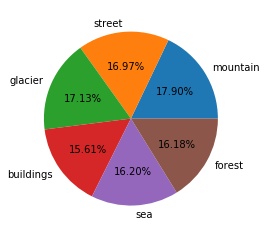

In [8]:
plt.pie(np.bincount(trainY),labels = class_label,autopct='%1.2f%%')

### looks like our train dataset has almost equal number of data in each class.

## few data preprocessing

In [9]:
trainX = trainX / 255.0
testX  = testX / 255.0
trainY = utils.to_categorical(trainY)
testY = utils.to_categorical(testY)

## since the data is loaded from pre-classified folders, lets shuffle the data

In [10]:
trainX,trainY = shuffle(trainX,trainY)
testX,testY = shuffle(testX,testY)

## lets view few data 

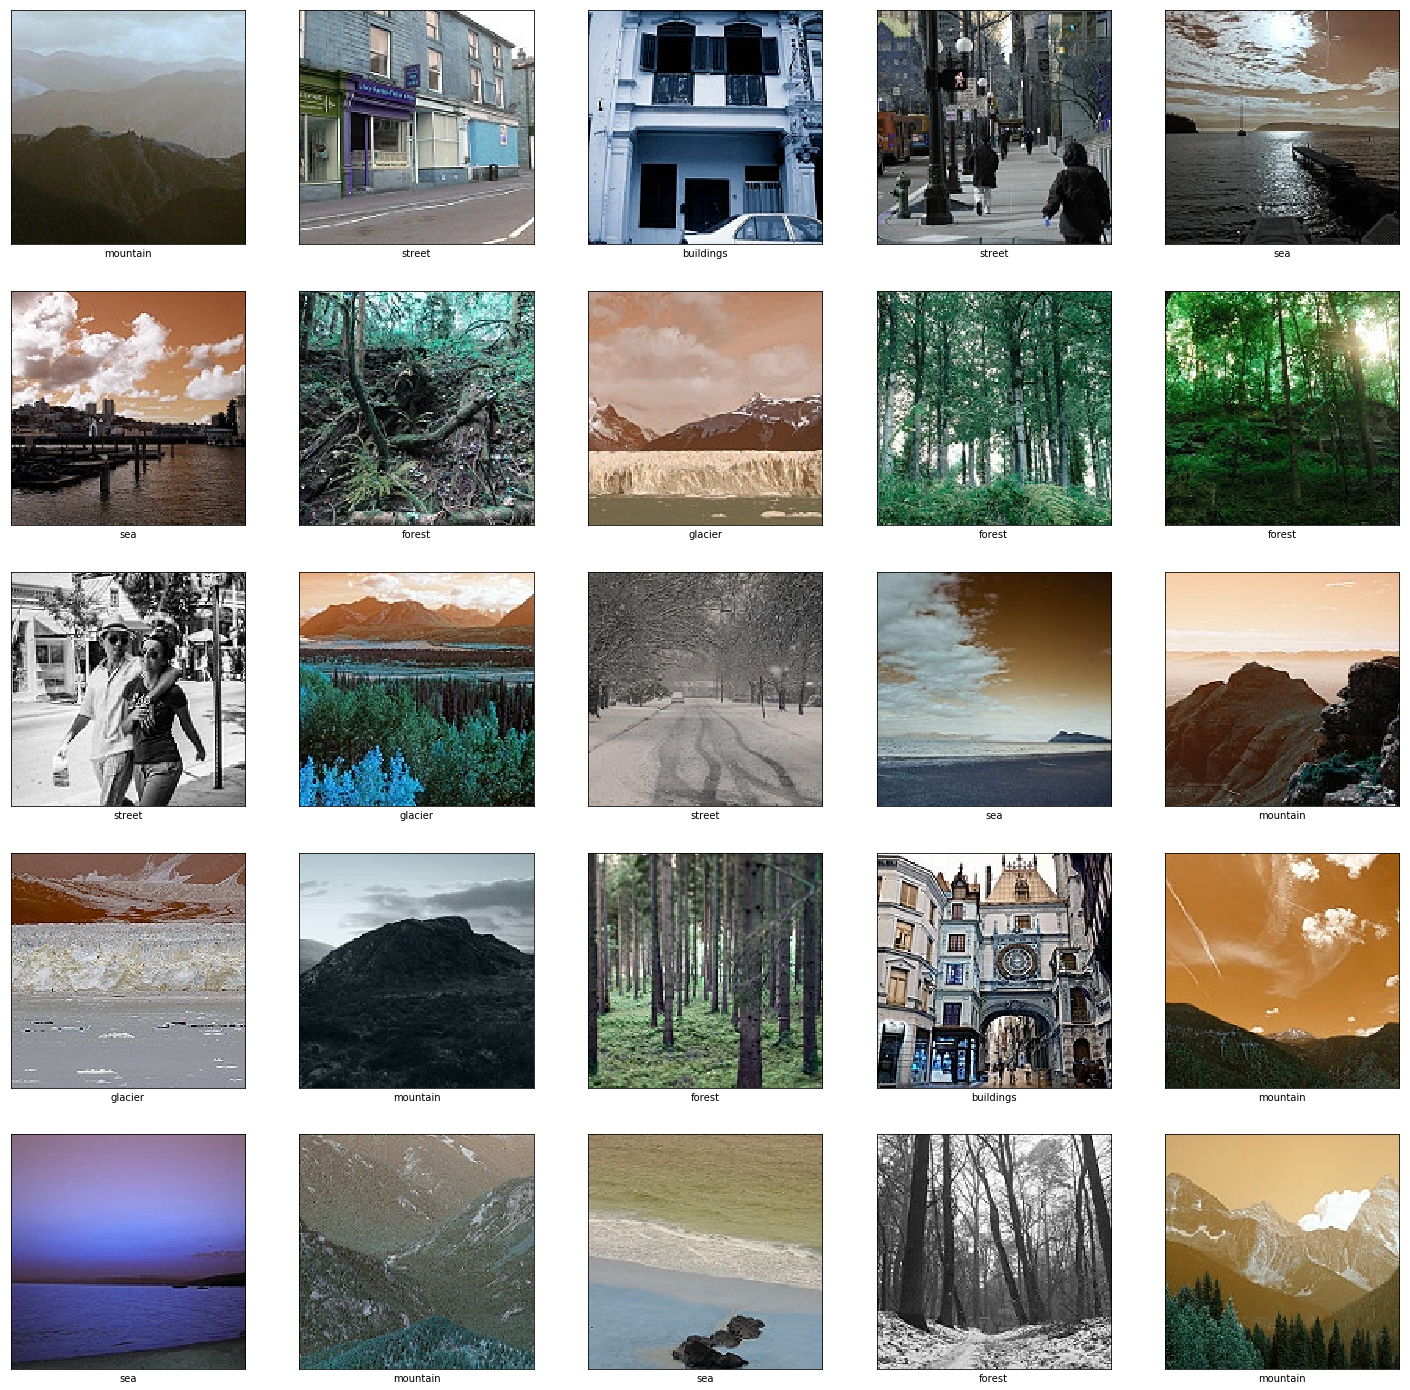

In [11]:
plt.figure(figsize=(25,25))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(trainX[i])
    plt.xlabel(class_label[np.argmax(trainY[i])])
    
plt.show()

## Build the model!
The architecture is as below,
1. input layer
2. stem
    1. Conv
    2. MaxPool
    3. Conv
    4. Conv
    5. MaxPool
3. inception module
    1. tower_1 - conv(1,1) - conv(3,3)
    2. tower_2 - conv(1,1) - conv(5,5)
    3. tower_3 - MaxPool(3,3) - conv(1,1)
4. concatenate the towers
5. flatten
6. Dense
7. output
    

In [12]:
input_img = Input(shape=(150,150,3))

stem_1 = Conv2D(64,(7,7),activation='relu',kernel_initializer='he_uniform',padding='same')(input_img)
stem_1 = MaxPooling2D((3,3))(stem_1)
stem_1 = Conv2D(64,(1,1),activation='relu',kernel_initializer='he_uniform',padding='same')(stem_1)
stem_1 = Conv2D(64,(3,3),activation='relu',kernel_initializer='he_uniform',padding='same')(stem_1)
stem_1 = MaxPooling2D((3,3))(stem_1)

tower_1 = Conv2D(64,(1,1),activation='relu',kernel_initializer='he_normal',padding='same')(stem_1)
tower_1 = Conv2D(64,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(tower_1)

tower_2 = Conv2D(64,(1,1),activation='relu',kernel_initializer='he_normal',padding='same')(stem_1)
tower_2 = Conv2D(64,(5,5),activation='relu',kernel_initializer='he_normal',padding='same')(tower_2)

tower_3 = MaxPooling2D((3,3),padding='same',strides=(1,1))(stem_1)
tower_3 = Conv2D(64,(1,1),activation='relu',kernel_initializer='he_normal',padding='same')(tower_3)

#tower_4 = Conv2D(64,(1,1),activation='relu',kernel_initializer='he_normal',padding='same')(stem_1)

output = concatenate([tower_1,tower_2,tower_3],axis=3)

output = Flatten()(output)
output = Dense(64,activation='relu',kernel_initializer='he_normal')(output)
#output = Dropout(0.2)(output)
output = Dense(6,activation = 'softmax')(output)

## declare optimization

In [13]:
model = Model(inputs =input_img,outputs=output)
epoch = 25
lrr = 0.001
opt = SGD(lr=lrr,momentum=0.9,decay=lrr/epoch)
model.compile(optimizer=opt,loss='categorical_crossentropy',metrics=['accuracy'])

## let's fit the model with training data and validate using test data

In [14]:
history = model.fit(trainX,trainY,epochs=epoch,batch_size=256,verbose=2,validation_data=(testX,testY))

Train on 14034 samples, validate on 3000 samples
Epoch 1/25
 - 18s - loss: 1.6916 - accuracy: 0.2582 - val_loss: 1.4249 - val_accuracy: 0.4353
Epoch 2/25
 - 13s - loss: 1.2409 - accuracy: 0.5000 - val_loss: 1.0850 - val_accuracy: 0.5743
Epoch 3/25
 - 13s - loss: 1.0079 - accuracy: 0.6141 - val_loss: 0.9533 - val_accuracy: 0.6400
Epoch 4/25
 - 13s - loss: 0.9018 - accuracy: 0.6642 - val_loss: 0.8601 - val_accuracy: 0.6757
Epoch 5/25
 - 13s - loss: 0.8288 - accuracy: 0.6919 - val_loss: 0.8057 - val_accuracy: 0.7103
Epoch 6/25
 - 13s - loss: 0.7752 - accuracy: 0.7106 - val_loss: 0.8232 - val_accuracy: 0.6847
Epoch 7/25
 - 13s - loss: 0.7297 - accuracy: 0.7310 - val_loss: 0.7752 - val_accuracy: 0.6987
Epoch 8/25
 - 13s - loss: 0.7040 - accuracy: 0.7423 - val_loss: 0.7097 - val_accuracy: 0.7410
Epoch 9/25
 - 13s - loss: 0.6955 - accuracy: 0.7470 - val_loss: 0.7463 - val_accuracy: 0.7263
Epoch 10/25
 - 13s - loss: 0.6439 - accuracy: 0.7683 - val_loss: 0.6613 - val_accuracy: 0.7630
Epoch 11/2

## validation accuracy saturates at 82%

## now let's plot the accuracy curves

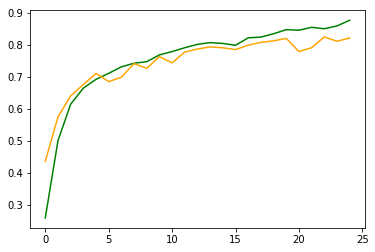

In [15]:
x = range(25)
plt.plot(x , history.history['accuracy'], color = 'green')
plt.plot(x , history.history['val_accuracy'], color = 'orange')

## this is better when compared to my initial curves. 
1. the batch size was increased from 64 to 256
2. Dense layer neurons were reduced from 128 to 64
3. for this model there is a stagnation in validation accuracy around 82%. this is the next assignment. to come out of this saturation.

## time to predict

In [16]:
predictions = model.predict(testX)

## plot some images with prediction and confidence % in prediction

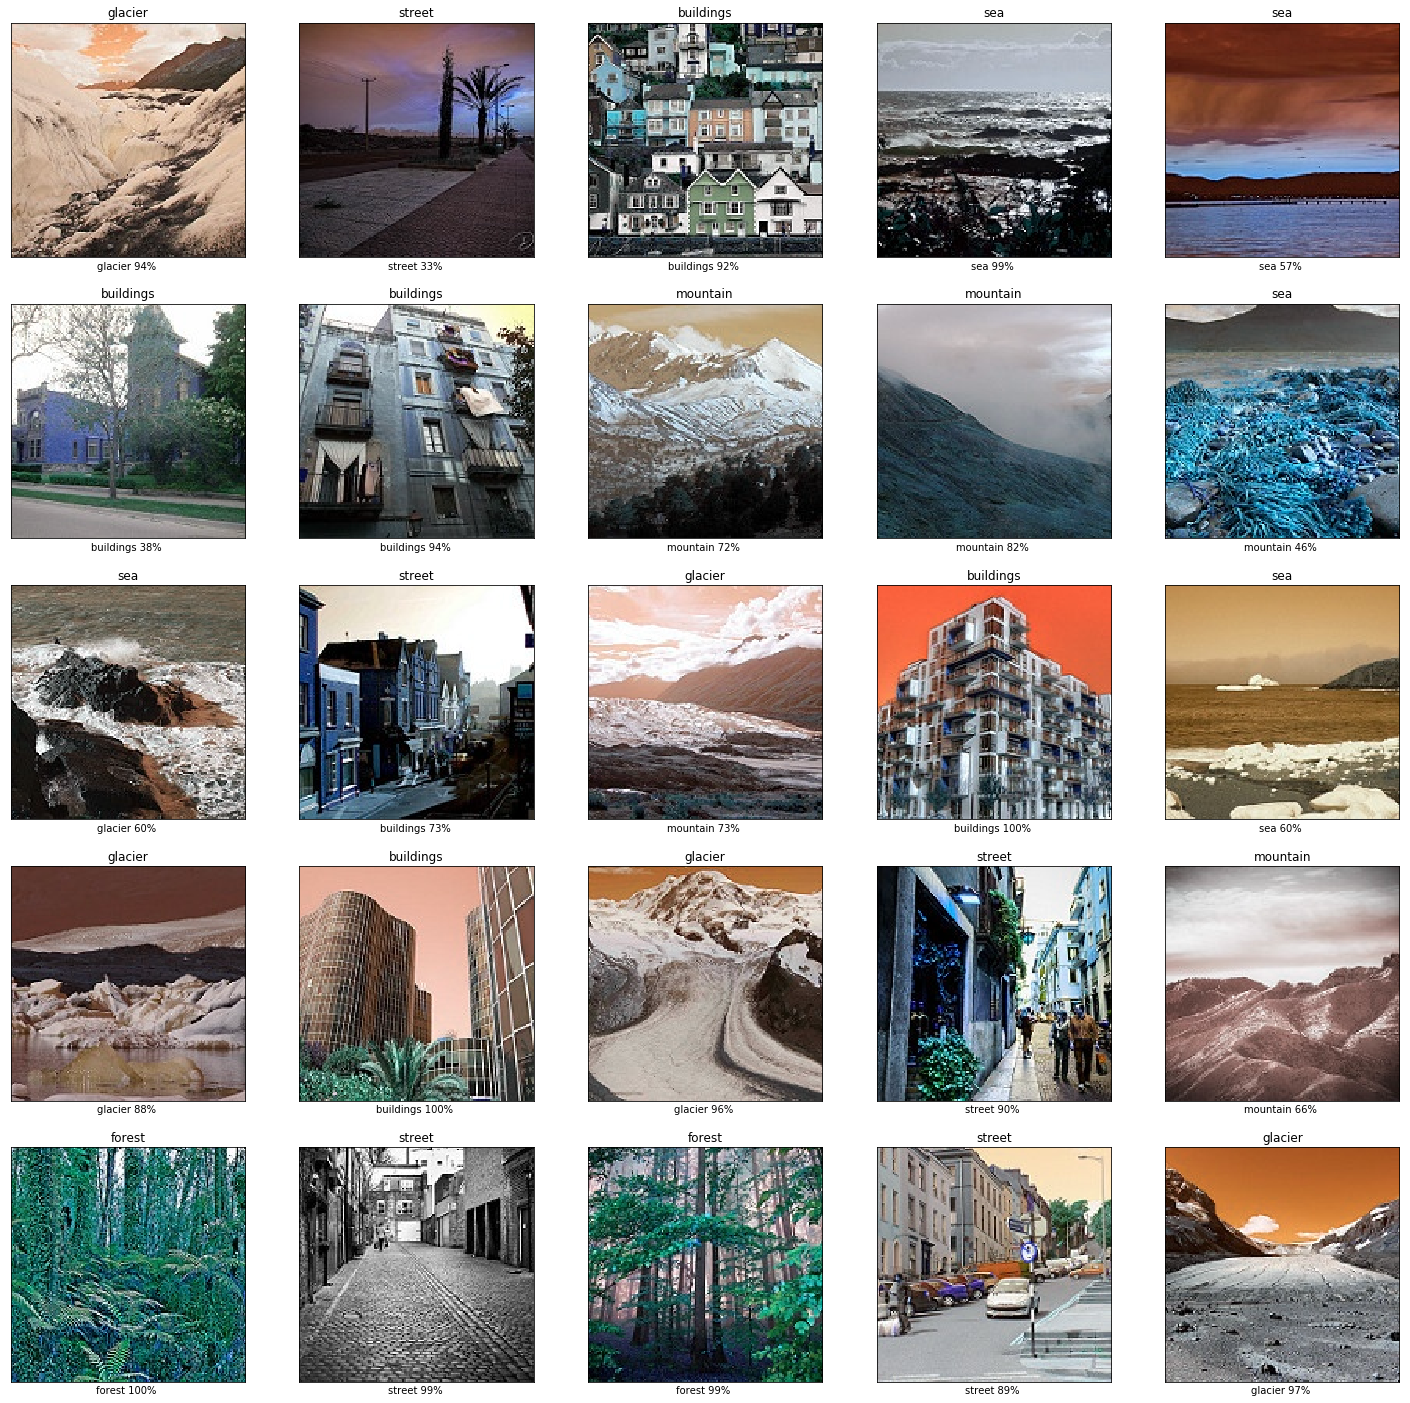

In [17]:
plt.figure(figsize=(25,25))

for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(testX[i])
    plt.xlabel("{} {:2.0f}% ".format(class_label[np.argmax(predictions[i])], 100*np.max(predictions[i])))
    plt.title(class_label[np.argmax(testY[i])])
plt.show()

## lets see what classes were mis-classified often

In [18]:
pred_label = np.argmax(predictions,axis=1)
act_label = np.argmax(testY,axis=1)
index = []
for i in range(len(act_label)):
    if act_label[i] != pred_label[i]:
        index.append(i)

len(index)

536

In [19]:
count = 0
wrong_images=[]
wrong_labels=[]
correct_labels=[]

for i in index:
    #print(class_label[act_label[i]],class_label[pred_label[i]])
    wrong_images.append(testX[i])
    wrong_labels.append(class_label[pred_label[i]])
    correct_labels.append(class_label[act_label[i]])
    count+=1
print(count)

536


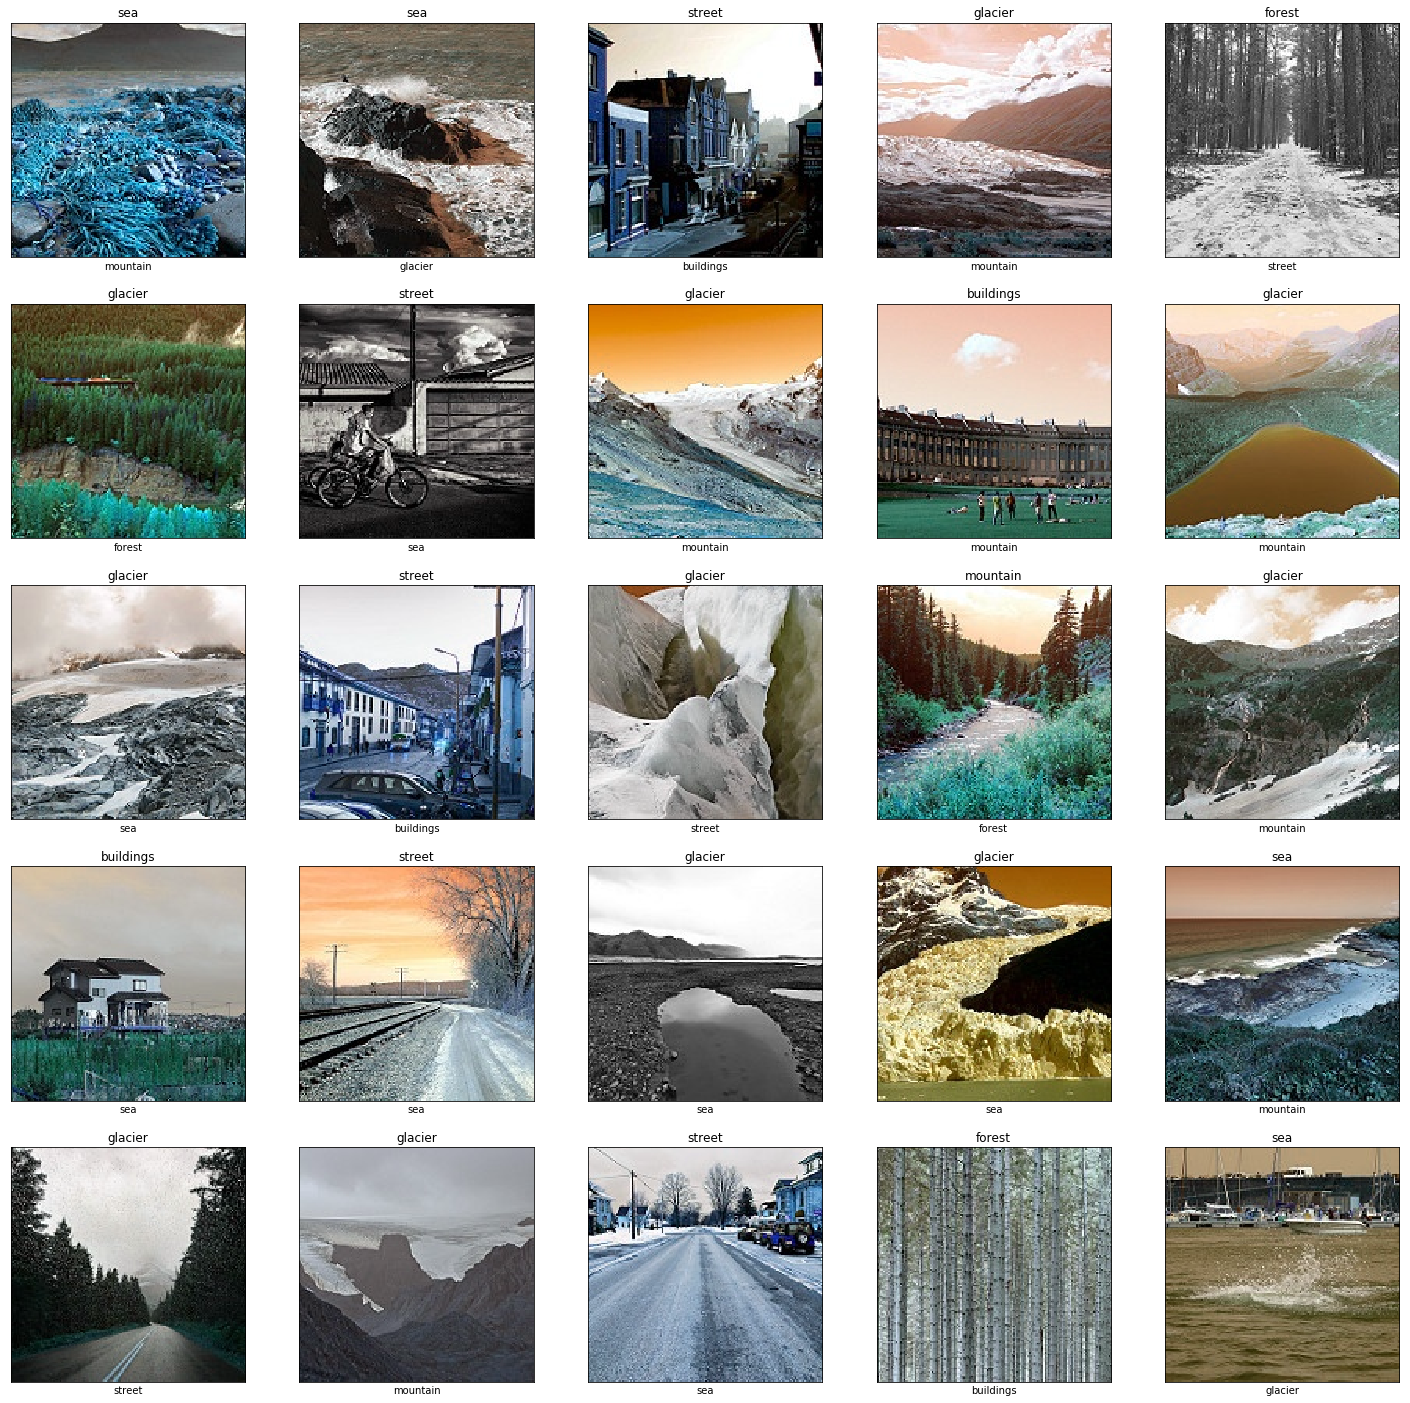

In [20]:
plt.figure(figsize=(25,25))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(wrong_images[i])
    plt.xlabel(wrong_labels[i])
    plt.title(correct_labels[i])
    
plt.show()

## there is a huge confusion between mountain and glacier which is obvious. secondly, white foam in sea misleads the model to glacier. thirdly, street and buildings are confused which is understandable. Finally, images with more than 2 classes in it are mis-classified.